In [1]:
import tensorflow as tf
import numpy as np
import os
import time

import os
import glob
import sys
import random
from argparse import ArgumentParser

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import multi_gpu_model 
import matplotlib
# matplotlib.use('agg')
import nibabel as nib
from skimage import transform
from importlib import reload
import matplotlib.pyplot as plt

# project imports
import datagenerators
import networks
import losses
import utils
import unet

sys.path.append('ext/neuron')
import neuron.callbacks as nrn_gen

sess = tf.keras.backend.get_session()

Using TensorFlow backend.
/om/user/wazeer/deform_gan/src/utils.py:84: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [ ]:
# import SimpleITK as sitk
# import matplotlib.pyplot as plt

# import cv2


# def show(x):
#     plt.imshow(sitk.GetArrayFromImage(x),'gray')
    
# def resample(image, transform):
#     reference_image = image
#     interpolator = sitk.sitkLinear
#     default_value = 100.0
#     return sitk.Resample(image, transform,
#                         interpolator, default_value)

# def distance(p1,p2):
#     return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [ ]:
x = []
x1 = []
y = []
for f in sorted(glob.glob('sample_data/orig/*.jpg')):
    x.append(plt.imread(f)[:,:,0])
for f in sorted(glob.glob('sample_data/masks/*.jpg')):
    x1.append(plt.imread(f)[:,:,0])
for f in sorted(glob.glob('sample_data/transformed/*.jpg')):
    y.append(plt.imread(f)[:,:,0])
    


In [ ]:
# print(len(x))
print(len(x))
print(x[0].shape)

# for i in range(len(x)):
#     plt.imshow(x[i],'gray')
#     plt.show()
#     plt.imshow(x1[i],'gray')
#     plt.show()

#     plt.imshow(y[i],'gray')
#     plt.show()


In [ ]:
img_size = 256
input_shape = (img_size, img_size, 1)

x = np.array(x).reshape((-1,)+input_shape)/255.
x1 = np.array(x1).reshape((-1,)+input_shape)/255.
y = np.array(y).reshape((-1,)+input_shape)/255.
y1 = np.repeat(np.zeros_like(y),repeats=2,axis=-1)
print(x.shape)

In [ ]:
input_shape = (img_size, img_size, 1)
src = tf.keras.layers.Input(input_shape)
mask = tf.keras.layers.Input(input_shape)

reload(networks)

nf_enc = [16, 32, 32, 32]
nf_dec = [32, 32, 32, 32, 8, 8]

model = networks.generator(src, mask, nf_enc, nf_dec, flow_out=False)
outputs = model.outputs

model.compile(loss='mse', optimizer='adam')
# model.fit([x,x1], y, epochs=5, batch_size=1)

In [10]:
model.fit([x,x1], y, epochs=100, batch_size=8)

Epoch 1/100
500/500 [==============================] - 3s 6ms/step - loss: 0.0010
Epoch 2/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 3/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 4/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 5/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 6/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 7/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 8/100
500/500 [==============================] - 3s 5ms/step - loss: 9.9804e-04
Epoch 9/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 10/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 11/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 12/100
500/500 [==============================] - 3s 6ms/step - loss: 0.0010
Epoch 13/

500/500 [==============================] - 3s 5ms/step - loss: 9.0767e-04
Epoch 97/100
500/500 [==============================] - 3s 6ms/step - loss: 8.9943e-04
Epoch 98/100
500/500 [==============================] - 3s 5ms/step - loss: 8.9939e-04
Epoch 99/100
500/500 [==============================] - 3s 5ms/step - loss: 9.2179e-04
Epoch 100/100
500/500 [==============================] - 3s 5ms/step - loss: 9.3276e-04


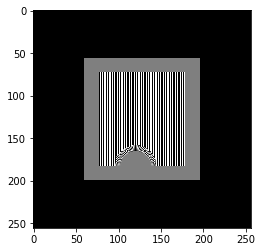

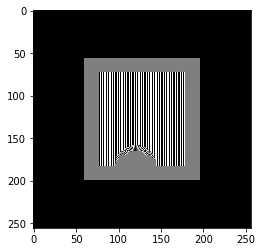

In [23]:
i=np.random.randint(len(x))
plt.imshow(np.squeeze(y[i]),'gray')
plt.show()

pred = model.predict([x[i:i+1], x1[i:i+1]])

plt.imshow(np.squeeze(pred[0]),'gray')
plt.show()

# plt.imshow(pred[1][0][:,:,0],'gray')
# plt.show()

# plt.imshow(pred[1][0][:,:,1],'gray')
# plt.show()

In [33]:
y1 = []
for x_,x1_ in zip(x,x1):
    y1.append(np.squeeze(model.predict([[x_], [x1_]])[0]))

[0.0000000e+00 1.8998687e-06 1.8998688e-06 ... 9.9999243e-01 9.9999619e-01
 1.0000000e+00]
(256, 256)


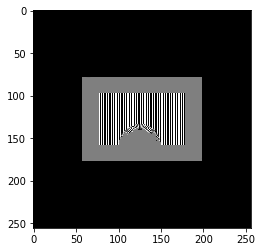

In [34]:
print(np.unique((y1)))
print(y1[0].shape)
plt.imshow(y1[10],'gray')

In [35]:
gan_y = np.array(y1).reshape((-1,)+input_shape)
gan_x = np.copy(x)

In [69]:
reload(networks)

real_a = tf.keras.layers.Input(input_shape)
real_b = tf.keras.layers.Input(input_shape)

mask_a = tf.keras.layers.Input(input_shape)
mask_b = tf.keras.layers.Input(input_shape)

nf_enc = [16, 32, 32, 32]
nf_dec = [32, 32, 32, 32, 32, 16, 16]

g_a2b = networks.gan_generator(real_a, nf_enc, nf_dec, flow_out=False)
d_a = networks.gan_discriminator(real_a)

g_b2a = networks.gan_generator(real_b, nf_enc, nf_dec, flow_out=False)
d_b = networks.gan_discriminator(real_b)

print(g_a2b.summary())
print(d_a.summary())

fake_b = g_a2b(real_a)
fake_a = g_b2a(real_b)

recon_b = g_a2b(fake_a)
recon_a = g_b2a(fake_b)

fake_a_pred = d_a(fake_a)
fake_b_pred = d_b(fake_b)

real_a_pred = d_a(real_a)
real_b_pred = d_a(real_b)

def mse(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_true-y_pred))

def mae(y_true,y_pred):
    return tf.reduce_mean(tf.abs(y_true-y_pred))

reconstructions = tf.keras.layers.Concatenate(axis=0, name='reconstructions')([recon_a, recon_b])
d_predictions = tf.keras.layers.Concatenate(axis=0, name='d_predictions')([fake_a_pred, fake_b_pred])
real = tf.keras.layers.Concatenate(axis=0, name='real')([real_a, real_b])

g_loss = mse(tf.ones_like(d_predictions), d_predictions) + mae(real, reconstructions)

d_A_loss = mse(tf.concat([tf.ones_like(real_a_pred), tf.zeros_like(fake_a_pred)],0), tf.concat([real_a_pred, fake_a_pred],0))
d_B_loss = mse(tf.concat([tf.ones_like(real_b_pred), tf.zeros_like(fake_b_pred)],0), tf.concat([real_b_pred, fake_b_pred],0))
d_loss = 0.5*(d_A_loss+d_B_loss)

lr = 2e-4

update_g_a2b = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5, beta2=0.999).minimize(g_loss, var_list=g_a2b.trainable_weights)
update_g_b2a = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5, beta2=0.999).minimize(g_loss, var_list=g_b2a.trainable_weights)
update_d_a = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5, beta2=0.999).minimize(d_loss, var_list=d_a.trainable_weights)
update_d_b = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5, beta2=0.999).minimize(d_loss, var_list=d_b.trainable_weights)

g_train = [update_g_a2b, update_g_b2a]
d_train = [update_d_a, update_d_b]

batch_size = 1

sess.run(tf.global_variables_initializer())

count = len(gan_x)//batch_size

start = time.time()
save_step = 100

for i in range(1000):
    random.shuffle(gan_x)
    random.shuffle(gan_y)
    
    total_g_loss = 0
    total_d_loss = 0
    
    for j in range(count):
        batch_x = gan_x[j:j+batch_size]
        batch_y = gan_y[j:j+batch_size]
        
        _,_, g_loss_val, d_loss_val = sess.run([g_train, d_train, g_loss, d_loss],
                                        feed_dict={real_a: batch_x, real_b:batch_y})
        
        total_g_loss+=g_loss_val
        total_d_loss+=d_loss_val
        
    print('Epoch {}, g_loss {} d_loss {}, time {}'.format(i,round(total_g_loss/count,4),round(total_d_loss/count,4),round(time.time()-start,4)))
    
    if i % save_step == 0:
        g_a2b.save('../models/g_a2b.h5')
        g_b2a.save('../models/g_a2b.h5')
        d_a.save('../models/d_a.h5')
        d_b.save('../models/d_b.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_330 (Conv2D)             (None, 128, 128, 16) 160         input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_277 (BatchN (None, 128, 128, 16) 64          conv2d_330[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_304 (LeakyReLU)     (None, 128, 128, 16) 0           batch_normalization_277[0][0]    
__________________________________________________________________________________________________
conv2d_331

Epoch 0, g_loss 0.5463 d_loss 0.1674, time 47.3693
Epoch 1, g_loss 0.5596 d_loss 0.1641, time 226.139
Epoch 2, g_loss 0.56 d_loss 0.164, time 262.4469
Epoch 3, g_loss 0.5601 d_loss 0.1639, time 298.6747
Epoch 4, g_loss 0.5604 d_loss 0.1639, time 334.6922
Epoch 5, g_loss 0.5605 d_loss 0.1638, time 370.8046
Epoch 6, g_loss 0.5609 d_loss 0.1636, time 406.9019
Epoch 7, g_loss 0.5612 d_loss 0.1634, time 442.9195
Epoch 8, g_loss 0.562 d_loss 0.163, time 478.9251
Epoch 9, g_loss 0.5629 d_loss 0.1627, time 514.5194
Epoch 10, g_loss 0.564 d_loss 0.1621, time 549.9319
Epoch 11, g_loss 0.564 d_loss 0.1621, time 585.347
Epoch 12, g_loss 0.5639 d_loss 0.1622, time 621.0043
Epoch 13, g_loss 0.5633 d_loss 0.1625, time 656.6341
Epoch 14, g_loss 0.5631 d_loss 0.1625, time 692.1578
Epoch 15, g_loss 0.5635 d_loss 0.1623, time 727.7261
Epoch 16, g_loss 0.5638 d_loss 0.1621, time 763.5039
Epoch 17, g_loss 0.5641 d_loss 0.162, time 799.2115
Epoch 18, g_loss 0.5644 d_loss 0.1619, time 835.1011
Epoch 19, g_lo

KeyboardInterrupt: 

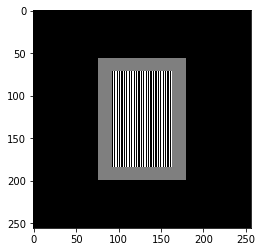

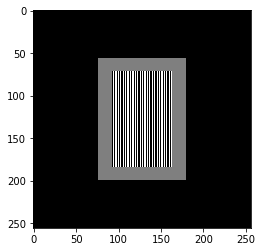

In [73]:
img = gan_x[0]
plt.imshow(np.squeeze(img),'gray')
plt.show()
pred = g_a2b.predict(np.expand_dims(img,0))
plt.imshow(np.squeeze(pred[0]),'gray')
plt.show()

In [64]:
reload(networks)
x_train = np.concatenate((gan_x,gan_y), axis=0)

d=networks.gan_discriminator(real_a)
outputs_shape=tuple(d.output.shape.as_list())
# print(outputs.shape.as_list())

y_train = np.concatenate((np.zeros((len(gan_x),)+outputs_shape[1:]), np.ones((len(gan_x),)+outputs_shape[1:])))
d.compile('adam', loss='mse', metrics=['acc'])
d.fit(x_train, y_train, epochs=20, batch_size=1)


Epoch 1/20
1000/1000 [==============================] - 37s 37ms/step - loss: 0.2555 - acc: 0.4922
Epoch 2/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0735 - acc: 0.9146
Epoch 3/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0163 - acc: 0.9849
Epoch 4/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0198 - acc: 0.9805
Epoch 5/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0197 - acc: 0.9805
Epoch 6/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0196 - acc: 0.9805
Epoch 7/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0196 - acc: 0.9805
Epoch 8/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0196 - acc: 0.9805
Epoch 9/20
 448/1000 [============>.................] - ETA: 4s - loss: 0.0191 - acc: 0.9810

KeyboardInterrupt: 

In [78]:
np.mean(abs(gan_y[0]-np.zeros_like(gan_y)))

0.11426204